# Adding progress bars to Learner

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_09b import *
import time
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time

One thing has been missing all this time, and as fun as it is to stare at a blank screen waiting for the results, it's nicer to have some tool to track progress.

## Imagenette Data

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
!ls -R {str(path)}

/root/.fastai/data/imagenette-160:
train  val

/root/.fastai/data/imagenette-160/train:
n01440764  n02979186  n03028079  n03417042  n03445777
n02102040  n03000684  n03394916  n03425413  n03888257

/root/.fastai/data/imagenette-160/train/n01440764:
n01440764_10026.JPEG  n01440764_172.JPEG    n01440764_5776.JPEG
n01440764_10027.JPEG  n01440764_1735.JPEG   n01440764_5781.JPEG
n01440764_10029.JPEG  n01440764_17454.JPEG  n01440764_5785.JPEG
n01440764_10040.JPEG  n01440764_17501.JPEG  n01440764_5802.JPEG
n01440764_10042.JPEG  n01440764_17514.JPEG  n01440764_5848.JPEG
n01440764_10043.JPEG  n01440764_1764.JPEG   n01440764_5861.JPEG
n01440764_10048.JPEG  n01440764_1766.JPEG   n01440764_5869.JPEG
n01440764_10066.JPEG  n01440764_1770.JPEG   n01440764_5879.JPEG
n01440764_10074.JPEG  n01440764_1775.JPEG   n01440764_5902.JPEG
n01440764_10095.JPEG  n01440764_17782.JPEG  n01440764_5908.JPEG
n01440764_1009.JPEG   n01440764_17789.JPEG  n01440764_5911.JPEG
n01440764_10108.JPEG  n01440764_1778.JPEG   n014

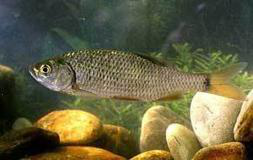

In [5]:
PIL.Image.open(path/'train/n01440764/n01440764_172.JPEG')

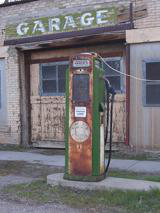

In [6]:
PIL.Image.open(path/'train/n03425413/n03425413_21577.JPEG')

In [7]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

In [8]:
cat_proc = CategoryProcessor()
il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=cat_proc)
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [9]:
nfs = [32] * 4

We rewrite the `AvgStatsCallback` to add a line with the names of the things measured and keep track of the time per epoch.

In [10]:
# export 
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
    
    def begin_fit(self):
        met_names = ['loss'] + [m.__name__ for m in self.train_stats.metrics]
        names = ['epoch'] + [f'train_{n}' for n in met_names] + [
            f'valid_{n}' for n in met_names] + ['time']
        self.logger(names)
    
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        self.start_time = time.time()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        stats = [str(self.epoch)] 
        for o in [self.train_stats, self.valid_stats]:
            stats += [f'{v:.6f}' for v in o.avg_stats] 
        stats += [format_time(time.time() - self.start_time)]
        self.logger(stats)

Then we add the progress bars... with a Callback of course! `master_bar` handles the count over the epochs while its child `progress_bar` is looping over all the batches. We just create one at the beginning or each epoch/validation phase, and update it at the end of each batch. By changing the logger of the `Learner` to the `write` function of the master bar, everything is automatically written there.

Note: this requires fastprogress v0.1.21 or later. 

In [11]:
# export 
class ProgressCallback(Callback):
    _order=-1
    def begin_fit(self):
        self.mbar = master_bar(range(self.epochs))
        self.mbar.on_iter_begin()
        self.run.logger = partial(self.mbar.write, table=True)
        
    def after_fit(self): self.mbar.on_iter_end()
    def after_batch(self): self.pb.update(self.iter)
    def begin_epoch   (self): self.set_pb()
    def begin_validate(self): self.set_pb()
        
    def set_pb(self):
        self.pb = progress_bar(self.dl, parent=self.mbar, auto_update=False)
        self.mbar.update(self.epoch)

By making the progress bar a callback, you can easily choose if you want to have them shown or not.

In [12]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [13]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [14]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.733640,0.400884,1.512729,0.454000,00:03
1,1.318734,0.560493,1.639656,0.462000,00:03


## Export

In [15]:
!./notebook2script.py 09c_add_progress_bar.ipynb

Converted 09c_add_progress_bar.ipynb to exp/nb_09c.py
